<a href="https://colab.research.google.com/github/KhizarAziz/pytorch-expeirments/blob/main/Pytorch_Experiements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import torch
import time
torch.manual_seed(0)
import torchvision
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torchvision import utils,transforms

In [ ]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

# **Download Dataset**

In [ ]:
# download dataset
!wget https://s3.amazonaws.com/fast-ai-imageclas/oxford-102-flowers.tgz
#extract
!tar -xvf oxford-102-flowers.tgz

# **Preprocess Dataset**

In [ ]:
# Creating Custom Dataset from this class
class FlowersDataset(Dataset):
  def __init__(self,root_dir,data_csv,transform=None):
    self.root_dir = root_dir

    self.data_csv = pd.read_csv(data_csv,sep=" ", header=None)
    self.data_csv.columns = ["imgPath", "id"] 
    self.transform = transform

  def __len__(self):
    return len(self.data_csv)

  def __getitem__(self,idx):
    image_path = os.path.join(self.root_dir,self.data_csv.iloc[idx,0])

    img = cv2.imread(image_path)
    img_class = self.data_csv.iloc[idx,1]
    if self.transform:
      tranformed_img = self.transform(img)
    

    single_row_dict_obj = {'image':tranformed_img,'class':img_class}
    return single_row_dict_obj


In [ ]:
#defining transforms
std = 0.5
mean = 0.5
tfms = transforms.Compose([transforms.ToTensor(),
                           transforms.Resize((224,224)),
                             transforms.Normalize(mean,std)])

In [ ]:
dataset_dir = '/content/oxford-102-flowers/'
#Training DataLoader
meta_csv = '/content/oxford-102-flowers/train.txt'
trainDataset = FlowersDataset(dataset_dir,meta_csv,tfms)
trainLoader = DataLoader(trainDataset,batch_size=64,shuffle=True)

# Validation DataLoader
meta_csv = '/content/oxford-102-flowers/valid.txt'
valDataset = FlowersDataset(dataset_dir,meta_csv,tfms)
valLoader = DataLoader(valDataset,batch_size=64,shuffle=True)

# Test DataLoader
meta_csv = '/content/oxford-102-flowers/test.txt'
testDataset = FlowersDataset(dataset_dir,meta_csv,tfms)
testLoader = DataLoader(testDataset,batch_size=64,shuffle=True)

# **Define Model**

In [ ]:
model = torchvision.models.resnet34(pretrained=True)

# **Freeze Initial Layers**

In [ ]:
# freezing network
for param in model.parameters():
  param.requires_grad = False
print(next(iter(model.layer4.parameters())).requires_grad)
print(next(iter(model.fc.parameters())).requires_grad)

# **Unfreeze Full Model**

In [ ]:
# freezing network
for param in model.parameters():
  param.requires_grad = True
print(next(iter(model.layer4.parameters())).requires_grad)
print(next(iter(model.fc.parameters())).requires_grad)

# **Train**

In [ ]:
#modifying top to spit out 102 categories -> as our dataset has 102 possible catergories
model.fc = nn.Linear(in_features=512, out_features=102, bias=True)
print(next(iter(model.layer4.parameters())).requires_grad)
print(next(iter(model.fc.parameters())).requires_grad)

In [11]:
print(next(iter(model.layer4.parameters())).requires_grad)
print(next(iter(model.fc.parameters())).requires_grad)

False
True


In [ ]:
#loading to gpu
model = model.to(device)

In [ ]:
loss_func = nn.CrossEntropyLoss()
lr = 0.02
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

In [14]:
accuracy_tracker = []

In [ ]:
total_epochs = 10
start_time = time.time()

for epoch in range(total_epochs):
  batch_loss = 0
  for batch,sample_dict in enumerate(trainLoader):
    images = sample_dict['image']
    labels = sample_dict['class']
    images =images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad() # reset gradients for new batch
    output = model(images) # forward pass
    loss = loss_func(output,labels) # calculate loss
    loss.backward() #backward pass
    optimizer.step() # update weights

    batch_loss += loss.item() # update batch loss

  print(f'Epoch: {epoch}/{total_epochs} - Training Loss: {batch_loss/len(trainLoader)} - ',end=' ')

  with torch.no_grad(): # disable autograd
    # Cross validation 
      test_loss = 0
      correct_preds = 0
      total_items = 0

      for batch,val_sample in enumerate(valLoader,1):
          images = val_sample['image']
          labels = val_sample['class']
          images = images.to(device) # loading to 'gpu' or 'cpu'
          labels = labels.to(device) ## loading to 'gpu' or 'cpu'

          # forward pass
          output_withLog = model(images)

          #loss
          batch_loss = loss_func(output_withLog,labels)
          test_loss += batch_loss.item()

          #check prediction
          output = torch.exp(output_withLog)
          pred = torch.argmax(output,1)
          total_items += labels.size(0)
          correct_preds += (pred == labels).sum().item()

      accuracy_tracker.append(correct_preds/total_items)
      print(f"Accuracy: {correct_preds/total_items}",end='\n')


end_time = time.time()
time_elapsed = end_time-start_time

print(f"Total_Epochs: {total_epochs}  - Accuracy: {correct_preds*100/total_items}%")
print(f'took {time_elapsed} seconds to train')

In [16]:
len(accuracy_tracker)

7

# **My Results**

In [ ]:
# 30 epochs on full Model (All layers unfrozen)
  # Accuracy = 15.58% :   Time: 559.05 Seconds
%matplotlib inline
plt.plot(accuracy_tracker,label="Accuracy")
plt.legend

In [ ]:
# Initial Layers frozen for 10 epochs, Unfrozen All model for 20 epochs
%matplotlib inline
plt.plot(accuracy_tracker,label="Accuracy")
plt.legend  

<function matplotlib.pyplot.legend>

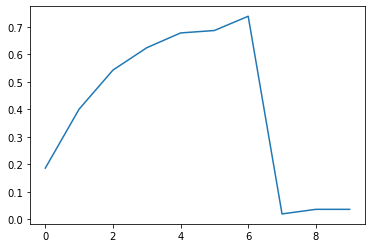

In [19]:
# Initial Layers frozen for 10 epochs, Unfrozen 10 for epochs
  # Accuracy = 76.76% :   Time:   96 Sec
%matplotlib inline
plt.plot(accuracy_tracker,label="Accuracy")
plt.legend  

# **Inference**

In [ ]:
model.to('cpu')
model.eval()
with torch.no_grad():
  sample = next(iter(testLoader))
  testImages = sample['image']
  testLabels = sample['class']
  output_withLog = model(testImages)
  output = torch.exp(output_withLog) #anti log
  pred = torch.argmax(output,1) # get highest probablity class (%)

  print(f"First output probability distribution {output[0]}, highest probablity calss {pred[0]} from distribution & total predictions {len(pred)}")
model = model.train()

In [ ]:
# display image with class

def denormalize(tensor):
  return tensor*std + mean

def show_img(img):
  img = img.numpy().transpose((1,2,0)) # converting tensor(3,224,224) to (224,224,3)
  # print(img.shape,type(img))
  img = denormalize(img)
  img = np.clip(img,0,1)
  plt.imshow(img)


test_img_id = 6
show_img(testImages[test_img_id])
print(pred[test_img_id])


In [ ]:
pred == testLabels

# **Playground**

In [ ]:
plt.figure()
for i in range(len(dataset)):
    sample = dataset[i]

    print(i, sample['image'].shape, sample['class'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    x = sample['image'].numpy()# convert to numpy img
    plt.imshow(x[1]) # just show 1 channel of image, because its in shape 3,224,224

    if i == 3:
        plt.show()
        break

In [ ]:
t = torch.tensor(4,4,2)

In [ ]:
t

In [ ]:
df = pd.read_csv('/content/oxford-102-flowers/train.txt',sep=" ", header=None)
df.columns = ["imgPath", "id"]

In [ ]:
df.shape

In [ ]:
df.head()

In [ ]:
#shape of batch
batch_of_data = next(iter(trainLoader))
batch_of_data['image'].shape,batch_of_data['class'].shape